In [6]:
import os
import sys
from lxml import etree
import glob
import numpy as np
import math
import argparse
import testTimeAugmentation
from predict_batch import generateXML, generateXMLout, mainDataset
import shutil 
from imutils import paths 
import xml.etree.ElementTree as ET
from xml.dom import minidom
from imutils import paths
      
def listarCuadrados(pathCarpeta):
    boxesAllXmls = []#list that stores all the lists of boxes of all xml
    boxes = []  # list that will contain all the squares of each xml
    prob = 0.5
    listDirectorios = os.scandir(path=pathCarpeta)#we list the files in the last folder

    for files in listDirectorios:
        if files.is_dir():
            break

    for fichero in os.listdir(files):#We go through the files in the folder
        (nombreFichero, extension) = os.path.splitext(fichero)
        
        if (extension == ".xml"):#we stay with those who are xmls and we go through them looking for a box
            boxes=[]
#             print(pathCarpeta+'/*/'+fichero)
            fichIguales = glob.glob(pathCarpeta+'/*/'+fichero)#
            for f in fichIguales:
                j = 0  # declaration of variables

                doc = etree.parse(f)
                filename = doc.getroot()  # we look for the root of our xml
                objetos = filename.findall("object")
                while j < len(objetos):
                    name = objetos[j].find("name").text
                    ymax = float(objetos[j].find("bndbox").find("ymax").text)
                    ymin = float(objetos[j].find("bndbox").find("ymin").text)
                    xmax = float(objetos[j].find("bndbox").find("xmax").text)
                    xmin = float(objetos[j].find("bndbox").find("xmin").text)
                    prob = "{0:.2f}".format(float(objetos[j].find("confidence").text))
                    boxes.append([name, xmin, ymin, xmax, ymax, prob])
                    j = j+1

        boxesAllXmls.append((nombreFichero,boxes))
    return boxesAllXmls

def uneBoundingBoxes(boxesAllXmls):

    boundingBox=[]
    listBox = []
    l=len(boxesAllXmls)
    while(l>0):
        boxPrim=boxesAllXmls[0]

        listBox.append(boxPrim)
        boxesAllXmls1=boxesAllXmls[1:]
        boxesAllXmls.remove(boxPrim)
        for box in boxesAllXmls1:
            if boxPrim[0]==box[0] and bb_intersection_over_union(boxPrim[1:5], box[1:5]) > 0.5:
                listBox.append(box)
                boxesAllXmls.remove(box)


        boundingBox.append(listBox)
        listBox = []
        l=len(boxesAllXmls)
    return boundingBox

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def nonMaximumSuppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return [0]
    # initialize the list of picked indexes
    pick = []
    probFinal = 0
    
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 1].astype(float)
    y1 = boxes[:, 2].astype(float)
    x2 = boxes[:, 3].astype(float)
    y2 = boxes[:, 4].astype(float)
    prob = boxes[:, 5].astype(float)
    
    for l in prob:
        probFinal = probFinal+l
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]

            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    return boxes[pick], probFinal

def models(listaModels, option, confidence_list):

    cam_types = ["FRONT", "FRONT_LEFT", "FRONT_RIGHT", "SIDE_RIGHT", "SIDE_LEFT"]

    if len(listaModels) is not len(confidence_list):
        print("Wrong confidence list parameters, different to number of models, setting default 0.3")
        confidence_list = [0.3]*len(listaModels)

    # 4. Generate xml
    for (model, confidence) in zip(listaModels, confidence_list):
        #If the model matches the name of the folder, we will predict it is only folder
#         for dir in os.listdir('salida/'):
#             if (os.path.splitext(os.path.basename('salida/'+model.pathPesos))[0]  + "_" + model.model_type) == dir:
        for cam_type in cam_types:
            model.predict('/home/project_x/data/validation', cam_type ,confidence)

#     # 5. We perform the ensemble method
    for dirOut in os.listdir('salida/'):
        for cam_type in cam_types:
            for file in list(paths.list_files('salida/'+dirOut + "/" + cam_type, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif"))):
                print(dirOut, cam_type, file)
                os.remove(file)

    ensembleOptions('salida/', option)

def ensembleOptions(datasetPath, option):
    
    #we get a list that contains as many pairs as there are xmls in the first folder,
    #these pairs indicate first the name of the xml file and then contain a list with all the objects of the xmls
    boxes = listarCuadrados(datasetPath)

    overlapThresh = 0.3
    
    #we separate by images and we get a list that groups the objects by the iou> 0.5
    for nombre, lis in boxes:
        pick = []
        resul = []

        #we check if the output folder where we are going to store the xmls exists
        if os.path.exists(datasetPath+"/output") == False:
            os.mkdir(datasetPath+"/output")

        #we look for the width, height and depth of the image fichIguales is gona be correspondant to num models
        fichIguales = glob.glob(datasetPath + '/*/' + nombre+'.xml')
        numFich = len(fichIguales)
        
        if numFich is 0:
            print(f"Excluding {nombre}")
            continue
            
        with open(datasetPath+"/output/"+nombre+".xml", "w") as file:
            
            doc = etree.parse(fichIguales[0])
            filename = doc.getroot()  # we look for the root of our xml
            wI = filename.find("size").find("width").text
            hI = filename.find("size").find("height").text
            d = filename.find("size").find("depth").text
            
            box = uneBoundingBoxes(lis)
            
            #now we pass the non-maximunSupression to each list within the list obtained
            for rectangles in box:
                lista = []

                for rc in rectangles:
                    lista.append(rc)
                pick = []
                                
                if option == 'consensus':
                    if len(np.array(lista))>=math.ceil(numFich/2):#if the number of boxes is greater than half the number of files
                        pick, prob = nonMaximumSuppression(np.array(lista), overlapThresh)
                        pick[0][5] = prob/numFich

                elif option == 'unanimous':
                    if len(np.array(lista))==numFich:#if the number of boxes is greater than half the number of files
                        pick,prob = nonMaximumSuppression(np.array(lista), overlapThresh)
                        pick[0][5] = prob / numFich

                elif option == 'affirmative':
                    pick,prob = nonMaximumSuppression(np.array(lista), overlapThresh)
                    pick[0][5] = prob / numFich

                if len(pick)!=0:
                    resul.append(list(pick[0]))
                
            file.write(generateXMLout(nombre, "", float(wI), float(hI), d, resul))

In [17]:
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", default = '../Images', help="path to the dataset of images")
ap.add_argument("-o", "--option",  default='consensus', help="option to the ensemble: affirmative, consensus or unanimous")

args, _ = ap.parse_known_args()
args = vars(args)

pathImg= args["dataset"]

option = args["option"]

#fichs = os.listdir(pathImg)

imgFolder = pathImg
#the user define configurations fichs

ed_dir = "/home/project_x/models/efficientdet/trained_models/efficientdet_waymo.pth"
model = testTimeAugmentation.WaymoEfficientDetPred(weightPath = ed_dir,
                                                   version = "vanilla",
                                                   scope = 'validation',
                                                   break_at = 2,
                                                   )

ed_dir_2 = "/home/project_x/models/efficientdet/trained_models/efficientdet_waymo_iter8200.pth"
model_2 = testTimeAugmentation.WaymoEfficientDetPred(weightPath = ed_dir_2,
                                                   version = "iter8200",
                                                   scope = 'validation',
                                                   break_at = 2,
                                                   )

# ed_dir_3 = "/home/project_x/models/efficientdet/trained_models/efficientdet_waymo_iter8200.pth"
# model_3 = testTimeAugmentation.WaymoEfficientDetPred(weightPath = ed_dir_2,
#                                                    version = "iter8200",
#                                                    scope = 'validation',
#                                                    break_at = 3,
#                                                    )

# efficientDet_2 = testTimeAugmentation.WaymoEfficientDetPred(weightPath="LUDO GIMME 2",version ="advanced")

listaModels = [model, model_2]
confidence_list = [0.1, 0.1]

models(listaModels, option, confidence_list)

Saving outputs at /home/project_x/ensembler/ensembleObjectDetection/TestTimeAugmentation/Alvaros/salida/efficientdet_waymo_EfficientDet_vanilla 

Accessing Images from /home/project_x/data/validation/FRONT 

[INFO] predicting on image 1 of 39987 in FRONT
[INFO] predicting on image 2 of 39987 in FRONT
Done with dummy 2 images 

Saving outputs at /home/project_x/ensembler/ensembleObjectDetection/TestTimeAugmentation/Alvaros/salida/efficientdet_waymo_EfficientDet_vanilla 

Accessing Images from /home/project_x/data/validation/FRONT_LEFT 

[INFO] predicting on image 1 of 39987 in FRONT_LEFT
[INFO] predicting on image 2 of 39987 in FRONT_LEFT
Done with dummy 2 images 

Saving outputs at /home/project_x/ensembler/ensembleObjectDetection/TestTimeAugmentation/Alvaros/salida/efficientdet_waymo_EfficientDet_vanilla 

Accessing Images from /home/project_x/data/validation/FRONT_RIGHT 

[INFO] predicting on image 1 of 39987 in FRONT_RIGHT
[INFO] predicting on image 2 of 39987 in FRONT_RIGHT
Done wi

In [9]:
import pickle
from PIL import Image
from io import BytesIO
import cv2
import matplotlib.pyplot as plt

def showImage(imagePath):
    
    image = cv2.imread(imagePath)
    
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

def combineImageAndPrediction(imagePath, xmlPath):
    
    with open(imagePath, 'rb') as file:
        img_dict = pickle.load(file)

    stream = BytesIO(img_dict['image'])
    image = Image.open(stream).convert("RGBA")
    image = np.array(image)
    stream.close()

    tree = ET.parse(xmlPath)
    root = tree.getroot()
    objects = root.findall('object')
    boxes = []

    for object in objects:
        category = object.find('name').text
        confidence = object.find('confidence')
        box = object.find('bndbox')
        x  = int(float(box.find('xmin').text))
        y = int(float(box.find('ymin').text))
        ymax = int(float(box.find('ymax').text))
        xmax = int(float(box.find('xmax').text))

        cv2.rectangle(image, (x,y),(xmax,ymax),(0, 255, 0), 2)
        cv2.putText(image, str(category) + str(confidence.text), (x-2,y-2), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    cv2.imwrite('prediction.jpg',image)

In [20]:
ensembleOptions('salida/', 'unanimous')

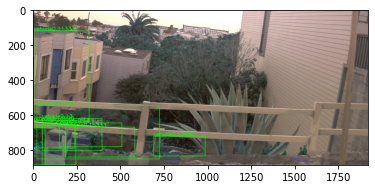

In [22]:
combineImageAndPrediction('/home/project_x/data/validation/SIDE_RIGHT/blob_130_frame_124.pickle', 
                          'salida/output/blob_130_frame_124_SIDE_RIGHT.xml')
showImage('prediction.jpg')

In [23]:
ensembleOptions('salida/', 'consensus')

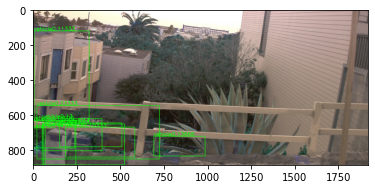

In [24]:
combineImageAndPrediction('/home/project_x/data/validation/SIDE_RIGHT/blob_130_frame_124.pickle', 
                          'salida/output/blob_130_frame_124_SIDE_RIGHT.xml')
showImage('prediction.jpg')

In [153]:
ensembleOptions('salida/', 'unanimous')

Excluding .ipynb_checkpoints


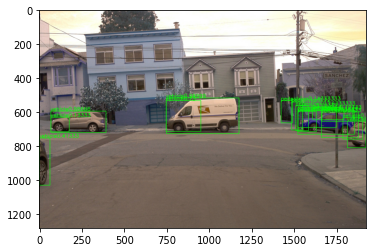

In [172]:
combineImageAndPrediction('/home/project_x/data/validation/FRONT/blob_132_frame_122.pickle', 
                          'salida/output/blob_132_frame_122_FRONT.xml')
showImage('prediction.jpg')